# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from operator import add
from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [3]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


#### Exercise 3.4

In [2]:
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
uidOne = ratings.map(lambda x : (x['userId'], 1)) #creates a tuple (userId, 1)
movidOne = ratings.map(lambda x : (x['movieId'], 1)) #creates a tuple (userId, 1)

#add values of all tuples with same key. Gives tuple (Id, occurences of this userId)
sortUser = sorted(uidOne.reduceByKey(add).collect()) 
sortMovie = sorted(movidOne.reduceByKey(add).collect()) 

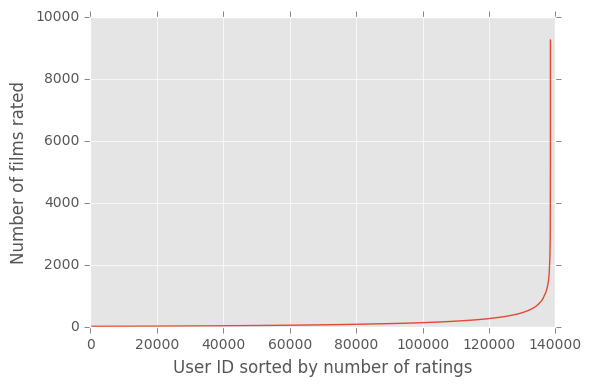

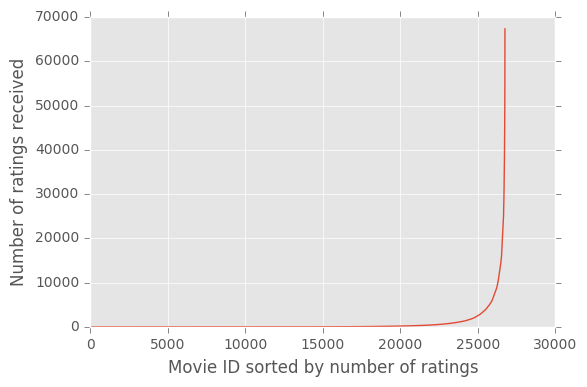

In [5]:
#changes tuples (Id, occurence) to a list of occurences
tableUsers = np.zeros(len(sortUser))
tableMovies = np.zeros(len(sortMovie))
for i in range(len(sortUser)):
    tableUsers[i] = sortUser[i][1]
for i in range(len(sortMovie)):
    tableMovies[i] = sortMovie[i][1]
    
#Plot data
plt.plot(sorted(tableUsers))
plt.xlabel('User ID sorted by number of ratings')
plt.ylabel('Number of films rated')
plt.show();

plt.plot(sorted(tableMovies))
plt.xlabel('Movie ID sorted by number of ratings')
plt.ylabel('Number of ratings received')
plt.show();

We immediately see the distribution is not uniform : some users rated barely a few films (min is around 20), when some others rated more that 9'000 films. 

Same applies for the films. Most films have almost no rating : first 20'000 films have less than 200 ratings and first 4'000 have 1 ratings. On the other hand, a handful of them have tens of thousands.

#### Exercise 3.5

In [4]:
F = open("my-ratings.txt", "r")

newEntries = F.read().split("\n")[:-1] #table of entries without empty last one
F.close()
x=sc.parallelize(newEntries)
joined = ratings.union(x)
# joinedOne = joined.map(lambda x : (x['userId'], 1)) #creates a tuple (userId, 1)
# training = joined.filter(lambda entry : int(entry["timestamp"])%10 == 1)
training = joined.filter(lambda entry : print(entry['timestamp'])).collect()
# user = joined.filter(lambda entry : entry[] == 138494)
# validation = joined.filter(lambda entry : entry['timestamp']%10 > 1)
# print("Previous was", ratings.count(),", personal is", x.count(),",joined is",joined.count())
# user.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 20 in stage 5.0 failed 1 times, most recent failure: Lost task 20.0 in stage 5.0 (TID 116, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/2.5.3.0-37/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/hdp/2.5.3.0-37/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/2.5.3.0-37/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-4-9290410d29f0>", line 9, in <lambda>
TypeError: string indices must be integers

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:227)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1433)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1421)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1420)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1420)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:801)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:801)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:801)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1601)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1590)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:622)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1882)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1953)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:934)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:323)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:933)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/2.5.3.0-37/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/usr/hdp/2.5.3.0-37/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/2.5.3.0-37/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-4-9290410d29f0>", line 9, in <lambda>
TypeError: string indices must be integers

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:227)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
